In [1]:
import pixiedust
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.layers import *
import sys, os
import pickle
from collections import OrderedDict as ODict

# %pixie_debugger
%matplotlib inline
sns.set(style='white', context='notebook', palette='tab10')

Pixiedust database opened successfully


Using TensorFlow backend.


## Import and Check data

In [2]:
datadir = os.getcwd() + '/../data'
datadict, filenames = ODict(), []
for files in os.listdir(datadir):
    try:
        with open(datadir + '/' + files, mode='r') as csvfile:
            datadict[files] = pd.read_csv(csvfile, header=0, encoding='ascii')
            csvfile.close()
        print('found file: {}'.format(files))
        filenames.append(files)
    except IsADirectoryError:
        print('skipping directory ./{}'.format(files))

datadict.keys(), filenames

found file: train.csv
found file: test.csv
found file: gender_submission.csv
skipping directory ./exported


(odict_keys(['train.csv', 'test.csv', 'gender_submission.csv']),
 ['train.csv', 'test.csv', 'gender_submission.csv'])

In [3]:
# %%
# Print out data, for quick look.

genderdata = datadict[filenames[-1]]
traindata = datadict[filenames[0]]
testdata = datadict[filenames[1]]

print(traindata.shape[0],"Rows")
traindata.info()

891 Rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
testdata.set_index('PassengerId')
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
genderdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


In [6]:
# check sample sizes per class per column
len(traindata)/traindata.nunique()

PassengerId      1.000000
Survived       445.500000
Pclass         297.000000
Name             1.000000
Sex            445.500000
Age             10.125000
SibSp          127.285714
Parch          127.285714
Ticket           1.308370
Fare             3.592742
Cabin            6.061224
Embarked       297.000000
dtype: float64

## Exploratory data analysis

In [7]:
train_nulls = (traindata.isnull().sum() / len(traindata)) * 100
train_nulls = train_nulls.drop(train_nulls[train_nulls == 0].index)
test_nulls = (testdata.isnull().sum() / len(testdata)) * 100
test_nulls = test_nulls.drop(test_nulls[test_nulls == 0].index)
train_missing = pd.DataFrame({'Training NaNs' :train_nulls})
train_missing.index.name = 'Metric'
test_missing = (pd.DataFrame({'Test NaNs' :test_nulls}))
test_missing.index.name = 'Metric'
all_missing = pd.merge(train_missing, test_missing, on='Metric', how='outer')
all_missing.head()

,Training NaNs,Test NaNs
Metric,,
Age,19.865320,20.574163
Cabin,77.104377,78.229665
Embarked,0.224467,NaN
Fare,NaN,0.239234


In [8]:
# Fill empty's with NaNs
traindata = traindata.fillna(np.nan)
testdata = testdata.fillna(np.nan)

### Exploring our Variables

    * PassengerId -> Ignore
    * Pclass -> Categorical -> Survival Probability
    * Name -> Categorical with Title (after Extraction) -> Survival Probability
    * Sex -> Categorical -> Survival Probability
    * Age -> Continous / Categorical (Binned) -> Survival Probability
    * SibSP -> Categorical -> Survival Probability
    * Parch -> Categorical -> Survival Probability
    * Ticket -> ? -> Needs Features
    * Fare -> Continous / Categorical (Binned) -> Survival Probability
    * Cabin -> ? (Deck | Deck Position | ?) -> Needs Features
    * Embarked -> Categorical -> Survival Probability

,Survived
Pclass,
3,491
1,216
2,184


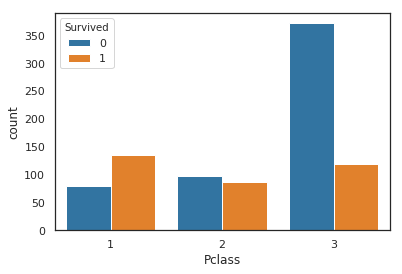

In [9]:
# Pclass
ax_pc = sns.countplot(x='Pclass',
                   hue="Survived",
                   data=traindata)

traindata[['Pclass',
           'Survived']].groupby('Pclass').count().sort_values(by='Survived',
                                                                    ascending=False)

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


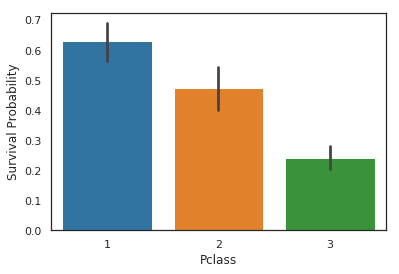

In [10]:
ax_pp = sns.barplot(x='Pclass',
                   y='Survived',
                   data=traindata)

ax_pp.set_ylabel("Survival Probability")

traindata[['Pclass',
           'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived',
                                                             ascending=False)

In [11]:
# Names

Prefixes = ['Mr.','Mrs.',
            'Master.','Miss.',
            'Don.','Dr.','Rev.',
            'Col.','Major.',
            'Ms.','Mme.','Lady.',
            'Sir.','Mlle.','Countess.',
            'Capt.','Jonkheer.']

def apply_prefix(s) -> str:
    
    Prefixes = ['Mr.','Mrs.','Master.','Miss.',
                'Don.','Dr.','Rev.','Col.',
                'Major.','Ms.','Mme.','Lady.',
                'Sir.','Mlle.','Countess.','Capt.','Jonkheer.']
    
    for _pf_ in Prefixes:
        if _pf_ in s:
            return _pf_
    return None

Pf_data = traindata.loc[:,('Name','Survived')]
Pf_data['Prefix'] = traindata.copy().loc[:,'Name'].astype(str).apply(apply_prefix) 

Text(0, 0.5, 'Survival Probability by Title')

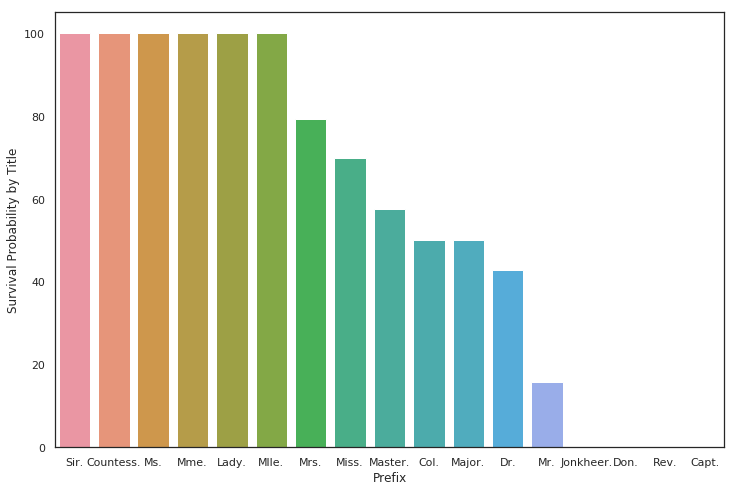

In [12]:
P = Pf_data[['Prefix',
             'Survived']].groupby('Prefix').mean().sort_values(by='Survived',
                                                               ascending=False) * 100
C = Pf_data[['Prefix',
             'Survived']].groupby('Prefix').count().sort_values(by='Survived',
                                                                ascending=False)
byNames = pd.merge(P,C,how='outer',on='Prefix')
byNames.columns = ['Survived(%)','Survived(N)']
byNames.index.name='Prefix'

fig = plt.figure(figsize=(12,8))

ax_np = sns.barplot(x=byNames.index,y=byNames['Survived(%)'])
ax_np.set_ylabel('Survival Probability by Title')

,Survived
Sex,
female,0.742038
male,0.188908


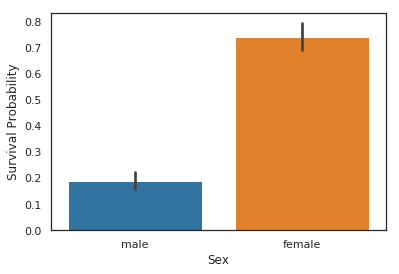

In [13]:
# by Gender

ax_gn = sns.barplot(x='Sex',y='Survived',data=traindata)
ax_gn.set_ylabel('Survival Probability')

traindata[['Sex','Survived']].groupby(['Sex']).mean()

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0, 0.5, 'Probability')

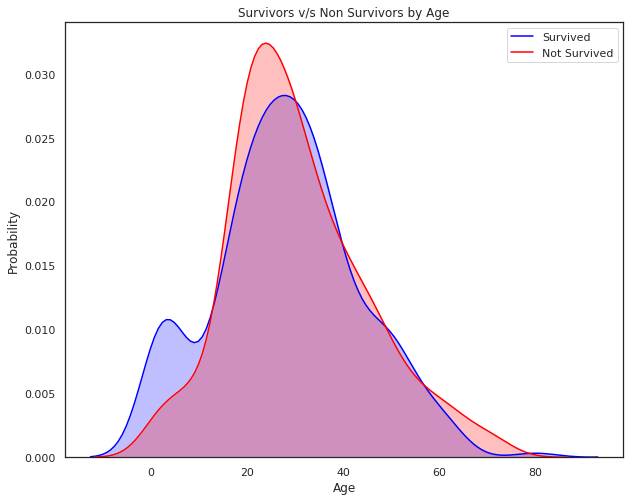

In [14]:
# by Age - Continuous KDE

fig = plt.figure(figsize=(10,8))

ax = sns.kdeplot(traindata.loc[(traindata['Survived']==1),('Age')],
                 color='b',
                 shade=True,
                 label='Survived')

ax = sns.kdeplot(traindata.loc[(traindata['Survived']==0),('Age')],
                 color='r',
                 shade=True,
                 label='Not Survived')

plt.title('Survivors v/s Non Survivors by Age')
plt.xlabel('Age')
plt.ylabel('Probability')

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Survived
Age_Binned,
0-10,0.593750
10-20,0.382609
20-30,0.365217
30-40,0.445161
40-50,0.383721
50-60,0.404762
60-70,0.235294
70-80,0.200000


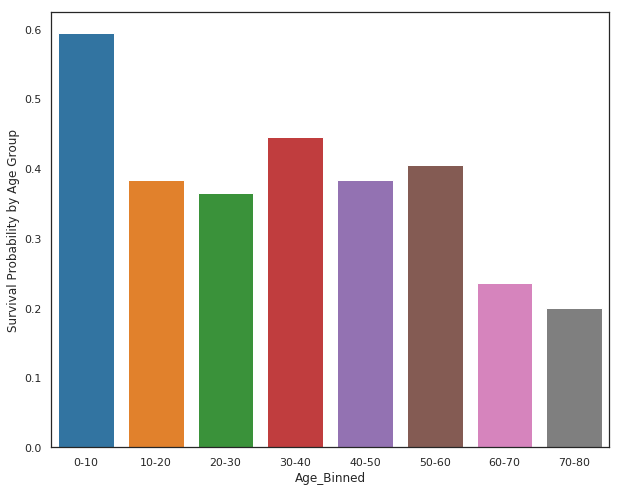

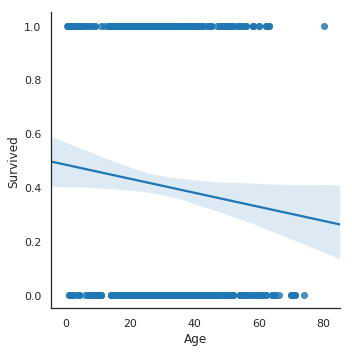

In [15]:
# by Age - Discrete Age Binning

fig = plt.figure(figsize=(10,8))

ageDF = traindata[['Age','Survived']]

maxage, minage = int(ageDF.Age.max()), int(ageDF.Age.min())
agebins = np.arange(minage, maxage+10, 10)
agelabels = [str(agebins[i])+'-'+str(agebins[i+1])
             for i in range(len(agebins)-1)]


ageDF['Age_Binned'] = pd.cut(ageDF.loc[:,('Age')],
                             bins=agebins,
                             labels=agelabels)


Binned_Probs = ageDF[['Age_Binned','Survived']].groupby(['Age_Binned']).mean()

ax_ag = sns.barplot(x=Binned_Probs.index,
                    y='Survived', 
                    data=Binned_Probs)

ax_lmag = sns.lmplot('Age','Survived',data=ageDF)

ax_ag.set_ylabel('Survival Probability by Age Group')

Binned_Probs

Text(0.5, 0, 'Number of siblings on board')

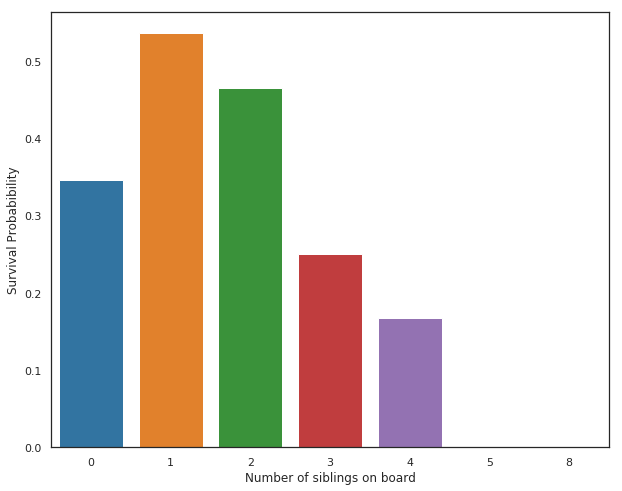

In [16]:
# by siblings on board

fig = plt.figure(figsize=(10,8))

sib_data = traindata[['SibSp', 'Survived']].groupby(['SibSp']).mean()

ax_sb = sns.barplot(x=sib_data.index, y='Survived', data=sib_data)
ax_sb.set_ylabel('Survival Probabibility')
ax_sb.set_xlabel('Number of siblings on board')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


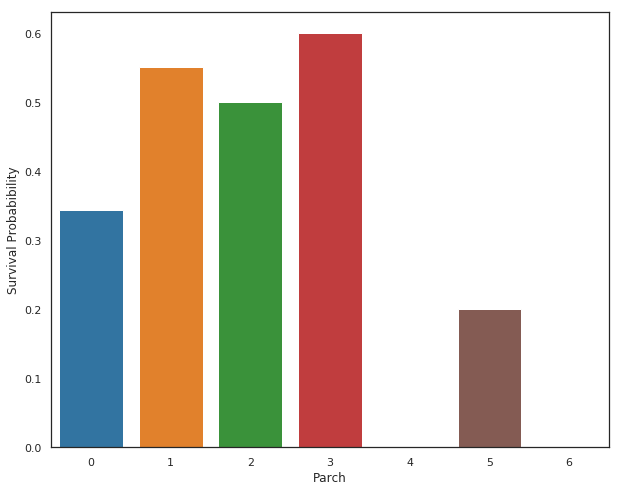

In [17]:
# by parents on board

fig = plt.figure(figsize=(10,8))

Parch_data = traindata[['Parch', 'Survived']].groupby(['Parch']).mean()

ax_sb = sns.barplot(x=Parch_data.index, y='Survived', data=Parch_data)
ax_sb.set_ylabel('Survival Probabibility')

Parch_data

Text(0, 0.5, 'Probability')

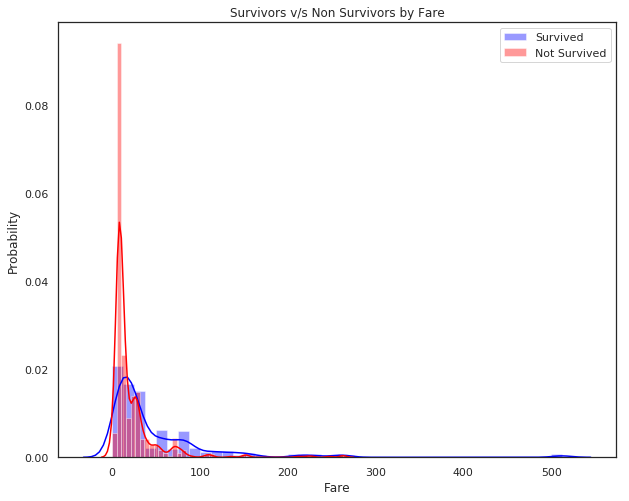

In [18]:
# by fares

fig = plt.figure(figsize=(10,8))

ax = sns.distplot(traindata.loc[(traindata['Survived']==1),('Fare')],
                 color='b',
                 label='Survived')

ax = sns.distplot(traindata.loc[(traindata['Survived']==0),('Fare')],
                 color='r',
                 label='Not Survived')

plt.title('Survivors v/s Non Survivors by Fare')
plt.legend()
plt.xlabel('Fare')
plt.ylabel('Probability')

In [19]:
# Cabin
traindata['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

,Survived
Embarked,
C,168
Q,77
S,644


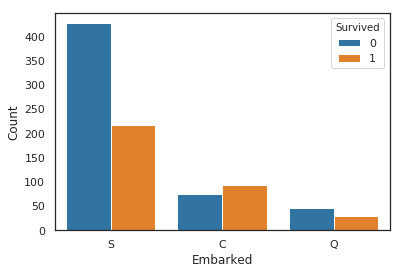

In [20]:
# Embarked
ax = sns.countplot(x='Embarked',hue='Survived',data=traindata)
ax.set_ylabel('Count')

traindata[['Embarked','Survived']].groupby(['Embarked']).count()

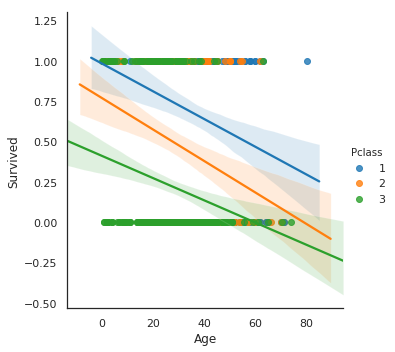

In [21]:
# Multiplots
# Age and Pclass

sns.lmplot('Age', 'Survived', data=traindata, hue='Pclass')

<Figure size 1152x384 with 0 Axes>

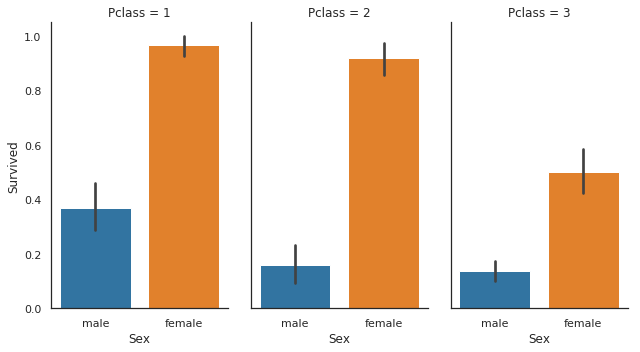

In [22]:
# Age, Sex and Pclass
fig = plt.figure(figsize=(12,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='Pclass', 
            data=traindata, kind='bar', aspect=0.6)

<Figure size 2688x384 with 0 Axes>

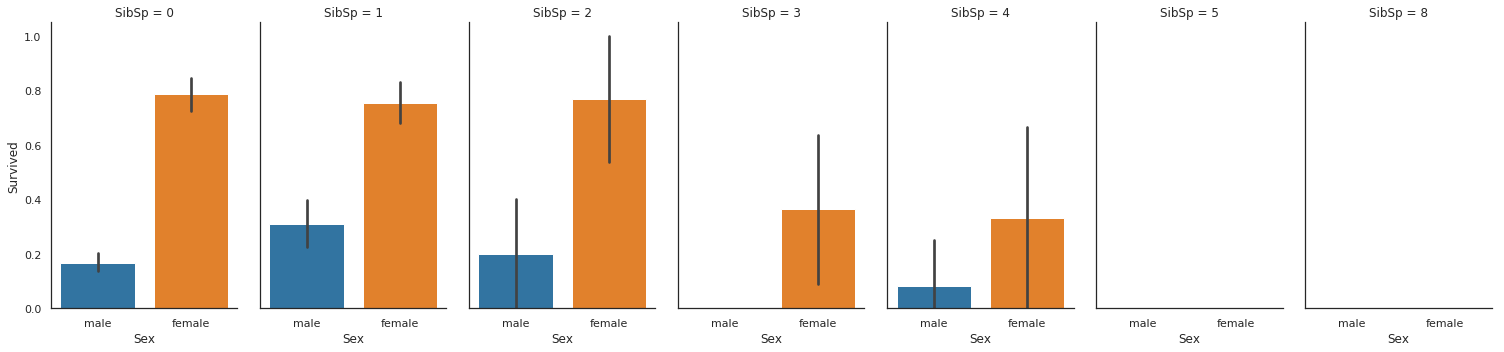

In [23]:
# Age, Sex, and Siblings on board
fig = plt.figure(figsize=(28,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='SibSp', 
            data=traindata, kind='bar', aspect=0.6)

<Figure size 2688x384 with 0 Axes>

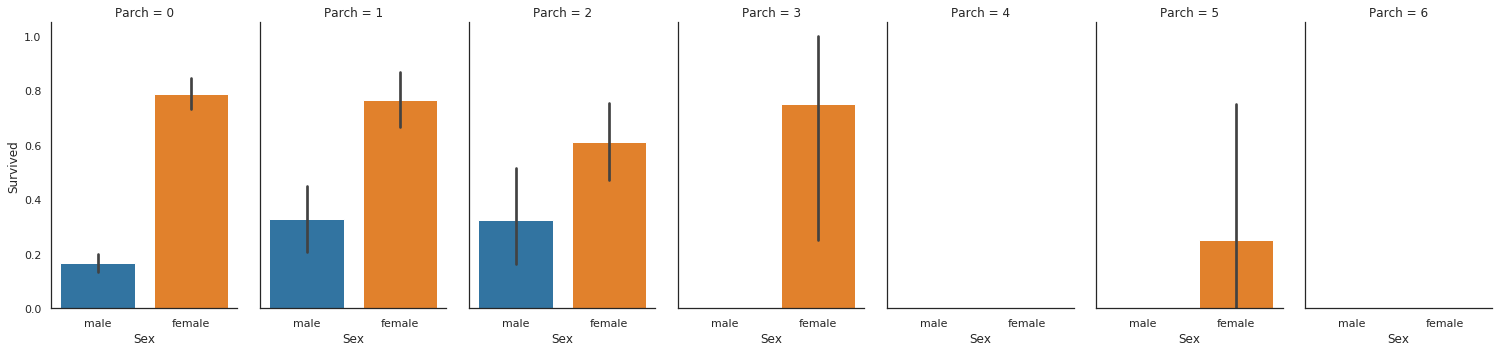

In [24]:
#Age, Sex and Parch
fig = plt.figure(figsize=(28,4), dpi=96)
sns.catplot(x='Sex', y='Survived', col='Parch', 
            data=traindata, kind='bar', aspect=0.6)

## Feature Engineering

In [25]:
# combining data

traindata['origin'] = 'train'
testdata['origin'] = 'test'
alldata = pd.concat([traindata, testdata], ignore_index=True, sort=False)
print(traindata.shape, testdata.shape, alldata.shape)
print(set(traindata.columns) - set(testdata.columns))
alldata.isnull().sum()

(891, 13) (418, 12) (1309, 13)
{'Survived'}


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
origin            0
dtype: int64

In [26]:
# passengerID -> droppping

alldata.drop(labels = ['PassengerId'], axis=1, inplace=True)

In [27]:
# Pclass - dummies
alldata['Pclass'] = alldata.Pclass.astype('category')
alldata = pd.get_dummies(alldata, columns=['Pclass'], prefix='Pclass')

In [28]:
# Name - Extract Prefixes
alldata['Prefix'] = alldata.astype(str).apply(lambda s: pd.Series(apply_prefix(s["Name"])),axis=1)
print(alldata.Prefix.unique())
alldata = pd.get_dummies(alldata, columns = ['Prefix'], prefix='Has_Title')

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.' nan]


In [29]:
alldata.columns

Index(['Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'origin', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Has_Title_Capt.', 'Has_Title_Col.', 'Has_Title_Countess.',
       'Has_Title_Don.', 'Has_Title_Dr.', 'Has_Title_Jonkheer.',
       'Has_Title_Lady.', 'Has_Title_Major.', 'Has_Title_Master.',
       'Has_Title_Miss.', 'Has_Title_Mlle.', 'Has_Title_Mme.', 'Has_Title_Mr.',
       'Has_Title_Mrs.', 'Has_Title_Ms.', 'Has_Title_Rev.', 'Has_Title_Sir.'],
      dtype='object')

In [30]:
#Name -> Drop Raw Names
alldata.drop(labels = ['Name'], axis=1, inplace=True)
alldata.head()

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,origin,...,Has_Title_Major.,Has_Title_Master.,Has_Title_Miss.,Has_Title_Mlle.,Has_Title_Mme.,Has_Title_Mr.,Has_Title_Mrs.,Has_Title_Ms.,Has_Title_Rev.,Has_Title_Sir.
0,0.0,male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,...,0,0,0,0,0,1,0,0,0,0
1,1.0,female,38.0,1,0,PC 17599,71.2833,C85,C,train,...,0,0,0,0,0,0,1,0,0,0
2,1.0,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,...,0,0,1,0,0,0,0,0,0,0
3,1.0,female,35.0,1,0,113803,53.1000,C123,S,train,...,0,0,0,0,0,0,1,0,0,0
4,0.0,male,35.0,0,0,373450,8.0500,NaN,S,train,...,0,0,0,0,0,1,0,0,0,0


In [31]:
#Sex -> Categorize

alldata = pd.get_dummies(alldata, columns=["Sex"], prefix="Is")
alldata.head()

,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,origin,Pclass_1,...,Has_Title_Miss.,Has_Title_Mlle.,Has_Title_Mme.,Has_Title_Mr.,Has_Title_Mrs.,Has_Title_Ms.,Has_Title_Rev.,Has_Title_Sir.,Is_female,Is_male
0,0.0,22.0,1,0,A/5 21171,7.2500,NaN,S,train,0,...,0,0,0,1,0,0,0,0,0,1
1,1.0,38.0,1,0,PC 17599,71.2833,C85,C,train,1,...,0,0,0,0,1,0,0,0,1,0
2,1.0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,0,...,1,0,0,0,0,0,0,0,1,0
3,1.0,35.0,1,0,113803,53.1000,C123,S,train,1,...,0,0,0,0,1,0,0,0,1,0
4,0.0,35.0,0,0,373450,8.0500,NaN,S,train,0,...,0,0,0,1,0,0,0,0,0,1


In [32]:
from fancyimpute import KNN

def KNNfill(df,usecols,predcol, knn_k=5):
    
    dfcpy = df.copy().fillna(value=float('NaN')).loc[:, usecols]
    minval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].min()
    meanval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].mean()
    maxval = dfcpy.loc[dfcpy[predcol].notnull(),(predcol)].max()
    
    predictor = KNN(k=knn_k, min_value=minval, max_value=maxval)
    print("Starting Imputation, Printing NaNs for Passed DataFrame::\n{}\n".format(dfcpy.isnull().sum()))
    print("{} values missing for {}".format(dfcpy[predcol].isnull().sum(),predcol))
    imputed_df = pd.DataFrame(data=predictor.fit_transform(dfcpy),
                             columns=usecols)
    imputed_df['orig_'+predcol] = dfcpy.loc[:, (predcol)]
    return imputed_df

In [33]:
usecols = ['Is_male','Is_female','Pclass', 'Parch', 'SibSp', 'Age',
           'Has_Title_Capt.','Has_Title_Col.', 'Has_Title_Countess.',
           'Has_Title_Don.','Has_Title_Dr.', 'Has_Title_Jonkheer.',
           'Has_Title_Lady.','Has_Title_Major.', 'Has_Title_Master.',
           'Has_Title_Miss.','Has_Title_Mlle.', 'Has_Title_Mme.',
           'Has_Title_Mr.', 'Has_Title_Mrs.','Has_Title_Ms.',
           'Has_Title_Rev.', 'Has_Title_Sir.']
imputed_df = KNNfill(alldata, usecols, 'Age')
alldata['Age'] = imputed_df.Age

print("OK!" if alldata.Age.isnull().sum()==0 else "Imputation Failed!")

imputed_df.loc[imputed_df['orig_Age'].isnull(),('orig_Age','Age')].head()

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Starting Imputation, Printing NaNs for Passed DataFrame::
Is_male                   0
Is_female                 0
Pclass                 1309
Parch                     0
SibSp                     0
Age                     263
Has_Title_Capt.           0
Has_Title_Col.            0
Has_Title_Countess.       0
Has_Title_Don.            0
Has_Title_Dr.             0
Has_Title_Jonkheer.       0
Has_Title_Lady.           0
Has_Title_Major.          0
Has_Title_Master.         0
Has_Title_Miss.           0
Has_Title_Mlle.           0
Has_Title_Mme.            0
Has_Title_Mr.             0
Has_Title_Mrs.            0
Has_Title_Ms.             0
Has_Title_Rev.            0
Has_Title_Sir.            0
dtype: int64

263 values missing for Age
Imputing row 1/1309 with 1 missing, elapsed time: 0.253
Imputing row 101/1309 with 1 missing, elapsed time: 0.255
Imputing row 201/1309 with 1 missing, elapsed time: 0.257
Imputing row 301/1309 with 2 missing, elapsed time: 0.258
Imputing row 401/1309 with 

,orig_Age,Age
5,NaN,25.6
17,NaN,25.6
19,NaN,37.2
26,NaN,25.6
28,NaN,30.6


In [34]:
# discretize age to 5 year bins.

alldata['Age'] = alldata['Age'].map(lambda s: int(s)//5)
print(sorted(list(alldata['Age'].unique())))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-1, 20)

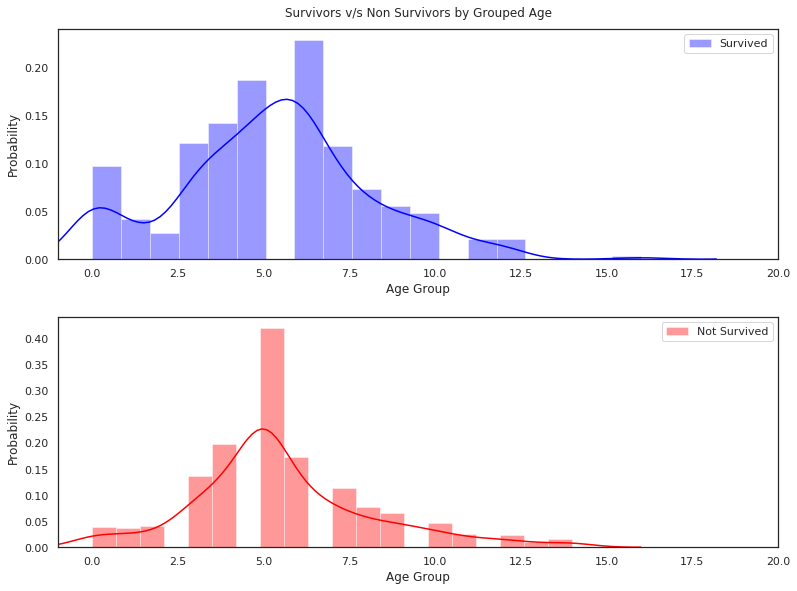

In [35]:
fig = plt.figure(figsize=(10,8))

ax_ag0 = fig.add_axes([0.0, 0.5, 1.0, 0.4]) # lbwh
ax_ag1 = fig.add_axes([0.0, 0.0, 1.0, 0.4])

ax_ag0 = sns.distplot(alldata.loc[(alldata['Survived']==1),('Age')],
                 color='b',
                 label='Survived', ax=ax_ag0)

ax_ag_1 = sns.distplot(alldata.loc[(alldata['Survived']==0),('Age')],
                 color='r',
                 label='Not Survived', ax=ax_ag1)

plt.title('Survivors v/s Non Survivors by Grouped Age',
          loc='center', pad = 300 )
ax_ag0.legend()
ax_ag0.set_ylabel('Probability')
ax_ag0.set_xlabel('Age Group')
ax_ag0.set_xlim(-1,20)
ax_ag1.legend()
ax_ag1.set_ylabel('Probability')
ax_ag1.set_xlabel('Age Group')
ax_ag1.set_xlim(-1,20)

In [36]:
# dummify


alldata = pd.get_dummies(alldata, columns=['Age'], prefix='In_AgeGRP')

In [ ]:
# Age - Use Sex, Pclass, Parch, SibSp, Prefix to Fill Age

from fancyimpute import KNN

minage = alldata.loc[alldata['Age'].notnull(),('Age')].min()
maxage = alldata.loc[alldata['Age'].notnull(),('Age')].max()
medianage = alldata.loc[alldata['Age'].notnull(),('Age')].mean()

cols = ['Sex', 'Pclass', 'Parch', 'SibSp', 'Prefix', 'Age']
targetdf = alldata.fillna(value=float('NaN')).copy().loc[:, cols]
predictage = KNN(k=5, min_value=minage, max_value=maxage)
imp_agesdf = pd.DataFrame(data=predictage.fit_transform(targetdf),
                          columns=cols)

imp_agesdf['orig_ages'] = targetdf.loc[:, ('Age')]
imp_agesdf.loc[imp_agesdf['orig_ages'].isnull() == True].head()

imp_minage = imp_agesdf.loc[alldata['Age'].notnull(),('Age')].min()
imp_maxage = imp_agesdf.loc[alldata['Age'].notnull(),('Age')].max()
imp_medianage = imp_agesdf.loc[alldata['Age'].notnull(),('Age')].mean()

print("Min:{}->{},Mean:{}->{},Max:{}->{}".format(minage,imp_minage,
                                                medianage, imp_medianage,
                                                maxage, imp_maxage))

Text(0, 0.5, 'Frequency')

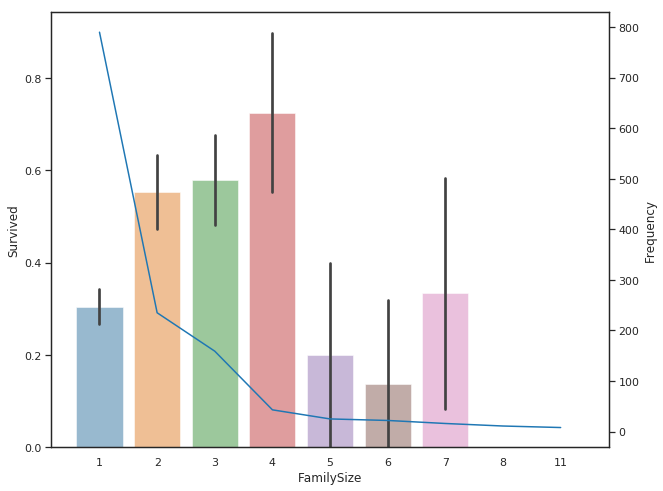

In [37]:
# SibSp and Parch -> Family Size

# switch of scipy.stats warning for enforced use of arr[np.array(seq)]
np.warnings.filterwarnings('ignore')

alldata[('FamilySize')] = alldata[('SibSp')] + alldata[('Parch')] + 1

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax = sns.barplot(x='FamilySize',y='Survived',data=alldata,alpha=0.5)
for c in ax.patches:
    c.set_zorder(0)

ax2 = ax.twinx()
sns.lineplot(x=np.arange(0, len(alldata.FamilySize.unique())),
                        y=alldata.FamilySize.value_counts(),
             ax=ax2)

ax2.set_ylabel('Frequency')

In [38]:
# create newer features for family sizes
alldata['FS_Single'] = alldata['FamilySize'].map(lambda s: 1 if s == 1 else 0)
alldata['FS_Small'] = alldata['FamilySize'].map(lambda s: 1 if s == 2 else 0)
alldata['FS_Medium'] = alldata['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
alldata['FS_Large'] = alldata['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

In [39]:
# Cat Codes for SibSp and Parch

alldata = pd.get_dummies(alldata, columns=["SibSp"])
alldata = pd.get_dummies(alldata, columns=["Parch"])

alldata.columns

Index(['Survived', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'origin', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Has_Title_Capt.', 'Has_Title_Col.',
       'Has_Title_Countess.', 'Has_Title_Don.', 'Has_Title_Dr.',
       'Has_Title_Jonkheer.', 'Has_Title_Lady.', 'Has_Title_Major.',
       'Has_Title_Master.', 'Has_Title_Miss.', 'Has_Title_Mlle.',
       'Has_Title_Mme.', 'Has_Title_Mr.', 'Has_Title_Mrs.', 'Has_Title_Ms.',
       'Has_Title_Rev.', 'Has_Title_Sir.', 'Is_female', 'Is_male',
       'In_AgeGRP_0', 'In_AgeGRP_1', 'In_AgeGRP_2', 'In_AgeGRP_3',
       'In_AgeGRP_4', 'In_AgeGRP_5', 'In_AgeGRP_6', 'In_AgeGRP_7',
       'In_AgeGRP_8', 'In_AgeGRP_9', 'In_AgeGRP_10', 'In_AgeGRP_11',
       'In_AgeGRP_12', 'In_AgeGRP_13', 'In_AgeGRP_14', 'In_AgeGRP_15',
       'In_AgeGRP_16', 'FamilySize', 'FS_Single', 'FS_Small', 'FS_Medium',
       'FS_Large', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4',
       'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
       'Parc

In [40]:
def parse_ticket(s:str)->(str, int):
    if s.strip(" ").isnumeric():
        return float('NaN'), int(s)
    elif s.strip(" ").isalpha():
        return s.strip(" "), int(0)
    else:
        try:
            xstr = s.replace('.','').replace('/','').strip(' ').split(' ')
            s,i = ''.join(xstr[0:-1]),xstr[-1]
            return s, int(i)
        except:
            xstr = s.replace('.','').replace('/','').strip(' ').split(' ')
            ss,i = ''.join(xstr[0:-1]),xstr[-1]
            print(s,ss, i)
    
alldata[["TKTHEADER","TKTNUM"]] = alldata.apply(lambda s: pd.Series(parse_ticket(s["Ticket"])),
                                                               axis=1)
alldata[['TKTHEADER','TKTNUM']].head()

,TKTHEADER,TKTNUM
0,A5,21171.0
1,PC,17599.0
2,STONO2,3101282.0
3,NaN,113803.0
4,NaN,373450.0


In [41]:
# cleaning up
alldata['TKTNUM'] = alldata.TKTNUM.astype(np.int32)
alldata['TKTHEADER'] = alldata.TKTHEADER.astype(str)
alldata.drop(labels=['Ticket'], axis=1, inplace=True)

alldata = pd.get_dummies(alldata, columns = ['TKTHEADER'], prefix='TKT_HEADER')

len(alldata.columns)

102

In [42]:
# Fares
print(alldata['Fare'].isnull().sum())

usecols = set(alldata.columns) - set(['Survived','Cabin',
                                      'origin','Embarked',])
predcol = 'Fare'

imputed_df = KNNfill(alldata,usecols,predcol,100)


1
Starting Imputation, Printing NaNs for Passed DataFrame::
In_AgeGRP_2             0
TKT_HEADER_FCC          0
In_AgeGRP_4             0
Has_Title_Mr.           0
TKT_HEADER_PC           0
Is_female               0
Has_Title_Capt.         0
Pclass_2                0
TKT_HEADER_SCAHBasle    0
TKT_HEADER_STONOQ       0
SibSp_1                 0
TKT_HEADER_SCA4         0
Has_Title_Rev.          0
TKT_HEADER_SOP          0
Has_Title_Countess.     0
Has_Title_Miss.         0
Has_Title_Mlle.         0
In_AgeGRP_15            0
TKT_HEADER_SOPP         0
Has_Title_Dr.           0
TKT_HEADER_LINE         0
TKT_HEADER_LP           0
SibSp_3                 0
In_AgeGRP_5             0
FS_Small                0
TKT_HEADER_SCParis      0
SibSp_4                 0
Parch_0                 0
In_AgeGRP_0             0
TKT_HEADER_PPP          0
                       ..
In_AgeGRP_6             0
SibSp_0                 0
In_AgeGRP_11            0
TKT_HEADER_WEP          0
Fare                    1
TKT_

Median:11.834761846748309, Predicted:33.2954792813456


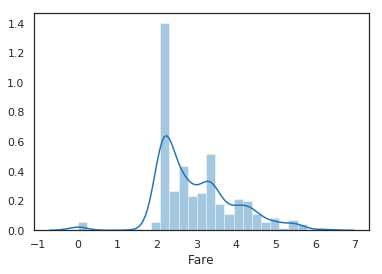

In [43]:
comp_fares = (float(imputed_df.loc[imputed_df['orig_Fare'].isnull(),('Fare')]),
              imputed_df.orig_Fare.mean())

print('Median:{}, Predicted:{}'.format(*comp_fares))

# logshift fares value 
alldata['Fare'] = np.log1p(imputed_df['Fare'])

sns.distplot(alldata['Fare'])

In [44]:
# discretizing fares

alldata['Fare'] = alldata['Fare'].map(lambda s: int(s/0.5))
alldata = pd.get_dummies(alldata, columns=['Fare'], prefix='Fare_group')

In [45]:
print(list(alldata.columns))

['Survived', 'Cabin', 'Embarked', 'origin', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Has_Title_Capt.', 'Has_Title_Col.', 'Has_Title_Countess.', 'Has_Title_Don.', 'Has_Title_Dr.', 'Has_Title_Jonkheer.', 'Has_Title_Lady.', 'Has_Title_Major.', 'Has_Title_Master.', 'Has_Title_Miss.', 'Has_Title_Mlle.', 'Has_Title_Mme.', 'Has_Title_Mr.', 'Has_Title_Mrs.', 'Has_Title_Ms.', 'Has_Title_Rev.', 'Has_Title_Sir.', 'Is_female', 'Is_male', 'In_AgeGRP_0', 'In_AgeGRP_1', 'In_AgeGRP_2', 'In_AgeGRP_3', 'In_AgeGRP_4', 'In_AgeGRP_5', 'In_AgeGRP_6', 'In_AgeGRP_7', 'In_AgeGRP_8', 'In_AgeGRP_9', 'In_AgeGRP_10', 'In_AgeGRP_11', 'In_AgeGRP_12', 'In_AgeGRP_13', 'In_AgeGRP_14', 'In_AgeGRP_15', 'In_AgeGRP_16', 'FamilySize', 'FS_Single', 'FS_Small', 'FS_Medium', 'FS_Large', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9', 'TKTNUM', 'TKT_HEADER_A2', 'TKT_HEADER_A4', 'TKT_HEADER_A5', 'TKT_HEADER_AQ3', 'TKT

In [46]:
# Cabins

def parse_cabin(s):
    
    Decks = ['A','B','C','D','E','F','G','T']
    DeckSet = set()
    sc = s
    
    if type(s)==float:
        return float('NaN'), float('NaN')
    else:
        for deck_ in Decks:
            if deck_ in s:
                DeckSet.add(deck_)
                s = s.replace(deck_,"")
        if s == "":
            return tuple(DeckSet), float('NaN')
        else:
            Rooms = tuple(int(_s) for _s in s.strip(' ').split(' '))
            return tuple(DeckSet), tuple(Rooms)
        
alldata[['Deck','Cabin']] = alldata.apply(lambda s: pd.Series(parse_cabin(s["Cabin"])),axis=1)
alldata.loc[alldata['Deck'].notnull(), ('Deck','Cabin')].head()

,Deck,Cabin
1,"(C,)","(85,)"
3,"(C,)","(123,)"
6,"(E,)","(46,)"
10,"(G,)","(6,)"
11,"(C,)","(103,)"


In [47]:
alldata['Deck'] = alldata['Deck'].map(lambda s: 'N/A' if type(s)!=tuple else ''.join(s))
alldata['Cabin'] = alldata['Cabin'].map(lambda s: 'N/A' if type(s)!=tuple else len(s))
alldata.Deck.unique(), alldata.Cabin.unique()

(array(['N/A', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'FG', 'FE', 'T'],
       dtype=object), array(['N/A', 1, 3, 2, 4], dtype=object))

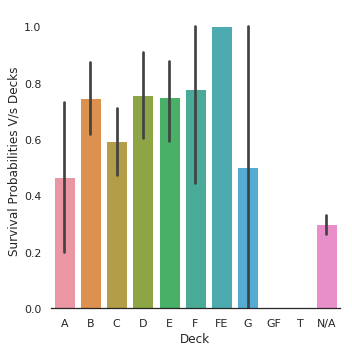

In [48]:
ax_dk  = sns.factorplot(x="Deck",y="Survived",data=alldata,kind="bar"
                        ,order=['A','B','C','D','E','F','FE','G','GF','T','N/A'])
ax_dk.despine(left=True)
ax_dk = ax_dk.set_ylabels("Survival Probabilities V/s Decks")

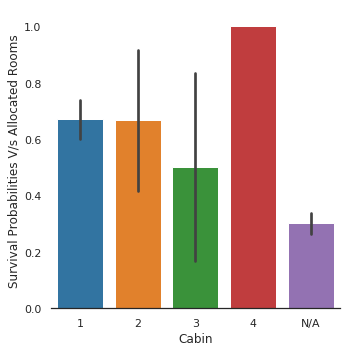

In [49]:
ax_cb  = sns.factorplot(x="Cabin",y="Survived",data=alldata,kind="bar"
                        ,order=[1,2,3,4,'N/A'])
ax_cb.despine(left=True)
ax_cb = ax_cb.set_ylabels("Survival Probabilities V/s Allocated Rooms")

In [50]:
alldata = pd.get_dummies(alldata, columns=['Deck'], prefix='Deck')
alldata = pd.get_dummies(alldata, columns=['Cabin'], prefix='Num_Rooms_is')
alldata.columns

Index(['Survived', 'Embarked', 'origin', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Has_Title_Capt.', 'Has_Title_Col.', 'Has_Title_Countess.',
       'Has_Title_Don.',
       ...
       'Deck_FE', 'Deck_FG', 'Deck_G', 'Deck_N/A', 'Deck_T', 'Num_Rooms_is_1',
       'Num_Rooms_is_2', 'Num_Rooms_is_3', 'Num_Rooms_is_4',
       'Num_Rooms_is_N/A'],
      dtype='object', length=128)

In [51]:
# Embarked
alldata['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [52]:
EmbMap = {'C':0, 'Q':1, 'S':2}

alldata['Embarked'] = alldata['Embarked'].map(lambda s: np.nan if type(s)==float else EmbMap[str(s)])

alldata['Embarked'].isnull().sum()

2

In [53]:
usecols = set(alldata.columns) - set(['Survived','origin'])

predcol = 'Embarked'

imputed_df = KNNfill(alldata,usecols,predcol,100)

Starting Imputation, Printing NaNs for Passed DataFrame::
Deck_B                  0
In_AgeGRP_2             0
TKT_HEADER_FCC          0
Deck_D                  0
Num_Rooms_is_2          0
Is_female               0
Deck_N/A                0
TKT_HEADER_SCAHBasle    0
TKT_HEADER_STONOQ       0
Has_Title_Rev.          0
Has_Title_Mlle.         0
Has_Title_Dr.           0
TKT_HEADER_LINE         0
SibSp_3                 0
In_AgeGRP_5             0
TKT_HEADER_SCParis      0
SibSp_4                 0
Deck_A                  0
In_AgeGRP_0             0
TKT_HEADER_PPP          0
In_AgeGRP_8             0
Has_Title_Mrs.          0
Parch_9                 0
Deck_FE                 0
FS_Large                0
Has_Title_Mme.          0
Has_Title_Lady.         0
FamilySize              0
Fare_group_7            0
Has_Title_Don.          0
                       ..
Fare_group_2            0
Num_Rooms_is_4          0
Deck_FG                 0
Fare_group_8            0
Parch_4                 0
Has_Ti

In [54]:
alldata['Embarked'] = imputed_df['Embarked']
alldata['Embarked'] = alldata.Embarked.map(lambda s: int(s))

alldata.Embarked.unique()

array([2, 0, 1])

In [55]:
#dummies
alldata = pd.get_dummies(alldata, columns=['Embarked'], prefix='Embarked_at')

In [56]:
tktnumbers = alldata.TKTNUM
alldata.drop(labels=['TKTNUM'], axis=1, inplace=True)

In [57]:
# forced typecasting

uint8check = lambda x: True if x.max() <= 255 else False

for col in alldata.columns:
    safestr = ''
    try:
        safestr = 'YES' if uint8check(alldata[col]) else '(!) NO'
        if uint8check(alldata[col]):
            alldata[col] = alldata[col].astype(np.uint8)
    except:
        print('(!) Exception at: ',col)
        safestr = '(!) NO'
    print("{}: UINT8 Safe:\033[1m{}\033[0m, Type:{}".format(col,
                                            safestr,
                                            alldata[col].dtype))




(!) Exception at:  Survived
Survived: UINT8 Safe:(!) NO, Type:float64
(!) Exception at:  origin
origin: UINT8 Safe:(!) NO, Type:object
Pclass_1: UINT8 Safe:YES, Type:uint8
Pclass_2: UINT8 Safe:YES, Type:uint8
Pclass_3: UINT8 Safe:YES, Type:uint8
Has_Title_Capt.: UINT8 Safe:YES, Type:uint8
Has_Title_Col.: UINT8 Safe:YES, Type:uint8
Has_Title_Countess.: UINT8 Safe:YES, Type:uint8
Has_Title_Don.: UINT8 Safe:YES, Type:uint8
Has_Title_Dr.: UINT8 Safe:YES, Type:uint8
Has_Title_Jonkheer.: UINT8 Safe:YES, Type:uint8
Has_Title_Lady.: UINT8 Safe:YES, Type:uint8
Has_Title_Major.: UINT8 Safe:YES, Type:uint8
Has_Title_Master.: UINT8 Safe:YES, Type:uint8
Has_Title_Miss.: UINT8 Safe:YES, Type:uint8
Has_Title_Mlle.: UINT8 Safe:YES, Type:uint8
Has_Title_Mme.: UINT8 Safe:YES, Type:uint8
Has_Title_Mr.: UINT8 Safe:YES, Type:uint8
Has_Title_Mrs.: UINT8 Safe:YES, Type:uint8
Has_Title_Ms.: UINT8 Safe:YES, Type:uint8
Has_Title_Rev.: UINT8 Safe:YES, Type:uint8
Has_Title_Sir.: UINT8 Safe:YES, Type:uint8
Is_fema

# Model Building

In [59]:
# Imports
from collections import Counter, OrderedDict
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier,VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import GridSearchCV
import multiprocessing

In [60]:
# prepare testing and training datasets

train = alldata.copy().loc[alldata['origin']=='train']
test = alldata.copy().loc[alldata['origin']=='test']


train.drop(labels=['origin'], axis=1, inplace=True)
train['Survived'] = train['Survived'].astype(np.uint8)
test.drop(labels=['Survived', 'origin'], axis = 1, inplace=True)

train.shape, test.shape

((891, 128), (418, 127))

In [61]:
X_train, Y_train = train.drop(labels=['Survived'], axis=1), train.Survived.astype(int)

X_train.shape, Y_train.shape, type(Y_train)

((891, 127), (891,), pandas.core.series.Series)

In [62]:
# cobbling together our algorithms

random_seed = 42
nCPU = 8
n_splits=9

# preparing for cv-folds
kfold = StratifiedKFold(n_splits)

classifiers = OrderedDict()
classifiers['SVC'] = SVC(random_state=random_seed)
classifiers['DecisionTree'] = DecisionTreeClassifier(random_state=random_seed)
classifiers['MLPClassifier'] = MLPClassifier(random_state=random_seed)
classifiers['KNN'] = KNeighborsClassifier()
classifiers['LinDA'] = LinearDiscriminantAnalysis()
classifiers['LogRegress'] = LogisticRegression(random_state=random_seed)
classifiers['RandomForest'] = RandomForestClassifier(random_state=random_seed)
classifiers['ADAboost'] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=random_seed),
                                            random_state=random_seed, learning_rate=1e-3)
classifiers['Gradboost'] = GradientBoostingClassifier(random_state=random_seed)
classifiers['ExtraTrees'] = ExtraTreesClassifier(random_state=random_seed)

# Voting is for the last

classifiers

OrderedDict([('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
                kernel='rbf', max_iter=-1, probability=False, random_state=42,
                shrinking=True, tol=0.001, verbose=False)),
             ('DecisionTree',
              DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, presort=False, random_state=42,
                          splitter='best')),
             ('MLPClassifier',
              MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
                     beta_2=0.999, early_stopping=False, epsilon=1e-08,
                     hidden_layer_sizes=(1

In [63]:
cv_scores = OrderedDict()

if __name__ == '__main__':
    for _key_ in classifiers.keys():
        cv_scores[_key_] = cross_val_score(classifiers[_key_],
                                            X_train, y=Y_train,
                                            scoring='accuracy',
                                            cv=kfold, n_jobs=nCPU,
                                            verbose=True)

cv_means, cv_std = OrderedDict(), OrderedDict()
for _key_ in classifiers.keys():
    cv_means[_key_] = cv_scores[_key_].mean()
    cv_std[_key_] = cv_scores[_key_].std()


cv_results = pd.DataFrame(data=list(classifiers.keys()), columns=['Algorithms'])
for _ix_ in range(n_splits):
    for _k_ in classifiers.keys():
        cv_results.loc[cv_results['Algorithms']==_k_,
                       'score_k='+str(_ix_)] = cv_scores[_k_][_ix_]
        cv_results['mean_score'] = cv_results['Algorithms'].map(cv_means)
        cv_results['stdev_score'] = cv_results['Algorithms'].map(cv_std)

cv_results[['Algorithms', 'mean_score']]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    1.3s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    1.4s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Don

,Algorithms,mean_score
0,SVC,0.818182
1,DecisionTree,0.795735
2,MLPClassifier,0.824916
3,KNN,0.794613
4,LinDA,0.827160
5,LogRegress,0.819304
6,RandomForest,0.799102
7,ADAboost,0.804714
8,Gradboost,0.819304
9,ExtraTrees,0.796857


Text(0.5, 1.0, 'Cross Validation Scores')

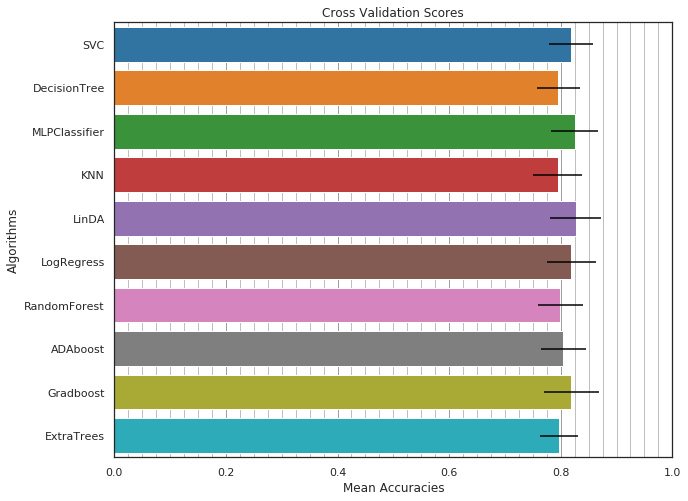

In [64]:
fig = plt.figure(figsize=(10,8))
ax_cvres = sns.barplot('mean_score', 'Algorithms', data=cv_results,
                       orient='h', xerr=cv_results.stdev_score)
ax_cvres.set_xlabel('Mean Accuracies')
axes = ax_cvres.axes
axes.set_xlim(0,1.0)
axes.set_xticks(np.arange(0,1.0, 0.025), minor=True)
axes.grid(color='gray', which='both', axis='x', alpha=0.5)
ax_cvres.set_title('Cross Validation Scores')

#### Tuning with GridSearchCV

In [65]:
GS_classifiers = OrderedDict()

def do_mpfit(model, grid_params, X=X_train, y=Y_train, strat_cv=kfold):
    
    gsearch_model = GridSearchCV(model, param_grid=grid_params,
                                 cv=strat_cv, scoring='accuracy',
                                 n_jobs=nCPU, pre_dispatch=2*nCPU,
                                 verbose=True)
    gsearch_model.fit(X, y)
    
    return gsearch_model.best_score_, gsearch_model.best_estimator_


In [66]:
#SVC
GS_SVC = SVC()

#gridparams
svc_grid_params = {'kernel' : ['rbf'],
                  'gamma' : [0.001, 0.01, 0.1],
                  'C' : [1, 10],
                  'degree' : [2, 3],
                  'shrinking' : [True],
                  'probability' : [True],
                  'decision_function_shape' : ['ovr'],
                  'tol' : [0.001],
                  'random_state' : [random_seed]}

if __name__ == '__main__':
    GS_classifiers['SVC'] = do_mpfit(GS_SVC, svc_grid_params)

print(GS_classifiers['SVC'][:]) #83.27

Fitting 9 folds for each of 12 candidates, totalling 108 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:    6.9s finished


(0.8327721661054994, SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))


In [67]:
#RandomForest

GS_RFC = RandomForestClassifier()

#gridparams

rfc_grid_params = {'n_estimators' : [100, 300],
                  'max_features' : [1, 3, 10],
                  'max_depth' : [7, 9, 11],
                  'criterion' : ['gini', 'entropy'],
                  'min_samples_split' : [2],
                  'min_samples_leaf' : [1],
                  'bootstrap' : [False],
                  'random_state' : [random_seed]
                  }

if __name__ == '__main__':
    GS_classifiers['RFC'] = do_mpfit(GS_RFC, rfc_grid_params)

print(GS_classifiers['RFC'][:]) #83.05

Fitting 9 folds for each of 36 candidates, totalling 324 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 324 out of 324 | elapsed:   14.6s finished


(0.8260381593714927, RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=11, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))


In [68]:
#ADABoost

AdaDTC = DecisionTreeClassifier()

GS_ABC = AdaBoostClassifier(AdaDTC, random_state=random_seed)

#gridparams

abc_grid_params = {'base_estimator__criterion' : ['gini', 'entropy'],
                  'base_estimator__splitter' : ['best', 'random'],
                  'base_estimator__max_depth' : [3, 5],
                  'base_estimator__max_features' : ['sqrt'],
                  'base_estimator__min_samples_split' : [2],
                  'base_estimator__min_samples_leaf' : [1],
                  'base_estimator__random_state' : [random_seed],
                  'base_estimator__presort' : [False],
                  'algorithm' : ['SAMME', 'SAMME.R'],
                  'n_estimators' : [50, 100],
                  'learning_rate' : [0.01, 0.001]              
                  }

if __name__ == '__main__':
    GS_classifiers['ABC'] = do_mpfit(GS_ABC, abc_grid_params)
    
print(GS_classifiers['ABC'][:]) #83.95

Fitting 9 folds for each of 64 candidates, totalling 576 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    6.9s


(0.8282828282828283, AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=42))


[Parallel(n_jobs=8)]: Done 576 out of 576 | elapsed:   12.3s finished


In [69]:
#GradientBoost

GS_GBC = GradientBoostingClassifier()

#gridparams

gbc_grid_params = {'learning_rate' : [0.01, 0.05],
                  'n_estimators' : [200, 300],
                  'max_depth' : [3, 4, 5],
                  'min_samples_split' : [0.1, 0.2, 0.3],
                  'min_samples_leaf' : [1],
                  'max_features' : ['log2'],
                  'validation_fraction' : [0.0],
                  'random_state' : [random_seed]
                  }

if __name__ == '__main__':
    GS_classifiers['GBC'] = do_mpfit(GS_GBC, gbc_grid_params)

print(GS_classifiers['GBC'][:]) #84.06

Fitting 9 folds for each of 36 candidates, totalling 324 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.6s


(0.8383838383838383, GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=0.2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.0,
              verbose=0, warm_start=False))


[Parallel(n_jobs=8)]: Done 324 out of 324 | elapsed:    9.1s finished


In [70]:
#ExtraTrees

GS_ETC = ExtraTreesClassifier()

#gridparams

etc_grid_params = {'n_estimators' : [50, 75, 100],
                  'criterion' : ['gini'],
                  'max_depth' : [4, 5, 6],
                  'min_samples_split' : [2, 0.05],
                  'min_samples_leaf' : [1],
                  'max_features' : ['sqrt'],
                  'random_state' : [random_seed]
                  }

if __name__ == '__main__':
    GS_classifiers['ETC'] = do_mpfit(GS_ETC, etc_grid_params)

print(GS_classifiers['ETC'][:]) #82.82

Fitting 9 folds for each of 18 candidates, totalling 162 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    1.3s


(0.8249158249158249, ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=6, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))


[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    2.4s finished


In [71]:
# saving model details

with open('../data/exported/GS_classifiers.dat', 'wb') as file:
    pickle.dump(GS_classifiers, file, protocol = -1)
    file.close()

In [72]:
# load saved file:

with open('../data/exported/GS_classifiers.dat', 'rb') as file:
    GSC_file = pickle.load(file, errors='strict')
    file.close()
    
GSC_file.keys()

odict_keys(['SVC', 'RFC', 'ABC', 'GBC', 'ETC'])

In [73]:
X_train.shape, Y_train.shape

((891, 127), (891,))

In [172]:
import keras
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from functools import partial

class mymlpmodel(keras.Model):
    
    mydense = partial(Dense, 
                      kernel_initializer='glorot_normal',
                      bias_initializer='glorot_uniform')
    
    def __init__(self, shape=X_train.shape[:1],
                  size=(50,50),
                  dropout_rate:float=0.25,
                  activation='relu',
                  optimizer = 'adam',
                  seed=random_seed):
        super(mymlpmodel, self).__init__()
        self.shape = shape
        self.size = size
        self.modelsize = size
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.optimizer = optimizer
        self.classifier = 'sigmoid'
        self.loss = 'binary_crossentropy'
        self.metric = 'accuracy'
        self.random_seed = seed
        self.model = None
        self.compiled = False
        self.Kwrap = None
        
    def __buildmodel(self) -> object:
        
        inp = Input(shape=self.shape)
    
        hidden = self.mydense(self.size[0],
                              activation=self.activation)(inp)
    
        for rems_ in self.size[1:]:
            drop = Dropout(rate=self.dropout_rate, 
                           seed=self.random_seed)(hidden)
            hidden = self.mydense(rems_,
                                  activation=self.activation)(drop)

        drop = Dropout(rate=self.dropout_rate,
                       seed=self.random_seed)(hidden)

        out =  self.mydense(1, activation=self.classifier)(drop)
        resmodel = Model(inputs=inp, outputs=out)
        return resmodel

    def __compilemodel(self, model) -> None:
        
        if model is None:
            raise ValueError('NoneType is not a model object!')
        else:
            self.model.compile(optimizer = self.optimizer,
                               loss = self.loss,
                               metrics = [self.metric])
            self.compiled = True

    def getmodel(self) -> None:
        
        self.model = self.__buildmodel()
        self.__compilemodel(self.model)
        
        return self.model
        
    def summary(self):
        self.__repr__()
    
    def __repr__(self):
        
        if self.model is  None:
            return '(!) Model not defined, run makemodel()'
        else:
            return str(self.model.summary())
        
    def Kwrapper(self):
        
        self.Kwrap =  KerasClassifier(build_fn = self.getmodel,
                                      input_arr = self.input_arr,
                                      size = self.size,
                                      dropout_rate = self.dropout_rate,
                                      activation = self.activation,
                                      optimizer = self.optimizer,
                                      random_seed = self.random_seed)
        return self.Kwrap
        
        
        
# test

mlpmodel = mymlpmodel()
mlpmodel.getmodel().summary()
mlpmodel.compiled

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 891)               0         
_________________________________________________________________
dense_165 (Dense)            (None, 50)                44600     
_________________________________________________________________
dropout_111 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_166 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_112 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 51        
Total params: 47,201
Trainable params: 47,201
Non-trainable params: 0
_________________________________________________________________


True

In [173]:
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid  = GridSearchCV(estimator=Kwrap, param_grid=param_grid, n_jobs=1, cv=kfold)

In [183]:
grid_result = grid.fit(X_train, Y_train)

NotImplementedError: 